In [3]:
# import common modules
import datetime
import math
import multiprocessing
import os
import random
import sys
import threading
import warnings
from utils import graph_utils as gu
import matplotlib.pyplot as plt
# limit the number CPUs to use
MAXCPUS = min(8, multiprocessing.cpu_count() // 2)

# read-only directory where the example data were extracted
DATA_PATH = r'C:\Users\amityu\Gel_Sheet_Data\pair_data\\'

# writable directory where large intermediate and output files will be saved
# must not be a network drive
SCRATCH_PATH = r'C:\Users\amityu\Gel_Sheet_Data\pair_scratch\\'

# for the BigDIPA workshop cluster
if os.path.exists('../../data/02_fcs_computation/'):
    DATA_PATH = '../../data/02_fcs_computation/'
    SCRATCH_PATH = '../../scratch/'

# use sequential MKL and OpenBLAS to prevent thread oversubscription
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
# os.environ['OMP_NUM_THREADS'] = '1'

import numpy

# set compiler and linker arguments for OpenMP
if sys.platform == 'win32':
    OPENMP_ARGS = '--compile-args=/openmp'
else:
    OPENMP_ARGS = '--compile-args=-fopenmp --link-args=-fopenmp'

# tell numba where to find CUDA NVVM on Windows
cuda_path = os.environ.get('CUDA_PATH', 'CUDA not found')
if os.path.exists(cuda_path):
    os.environ['PATH'] += r';%s\bin;%s\nvvm\bin' % (cuda_path, cuda_path)
    os.environ['CUDA_HOME'] = cuda_path

# ignore warnings
warnings.simplefilter('ignore')

# acquire a lock object to force single threaded execution
THREADLOCK = threading.RLock()

# initialize random number generators
random.seed(42)
numpy.random.seed(42)

# display plots within Jupyter notebook
%matplotlib inline

# detect if CUDA is available
try:
    import cupy

    SKIP_CUDA = False
except ImportError:
    SKIP_CUDA = True

# record the current time
START_TIME = datetime.datetime.now()

In [4]:
PROJECT_PATH = 'C:/Users/amityu/DataspellProjects/gel_sheets/'
DATA_PATH = 'C:/Users/amityu/Gel_Sheet_Data/'
#DATA_PATH = r'D:\amityu\backoffice_data\\'

movie = 'cca300'
ADD_PATH = os.path.join(PROJECT_PATH, "add_data/", movie + "/")

MOVIE_PATH = DATA_PATH + movie + '/'
GRAPH_PATH = 'C:/Users/amityu/Gel_Sheet_Graph/'
import numpy as np

SIMULATION_DATA = np.load(MOVIE_PATH + 'np/height.npy')
SIMULATION_DATA[np.isnan(SIMULATION_DATA)] = np.nanmean(SIMULATION_DATA)

In [5]:
gel = np.load(MOVIE_PATH + 'np/gel_norm.npy', mmap_mode='r')
membrane = np.load(MOVIE_PATH + 'np/membrane.npy')
mem_intensity = gu.values_3d(gel, membrane+3)
surface = np.load(MOVIE_PATH + 'np/height.npy')
sur_intensity = gu.values_3d(gel, surface-3)

In [6]:
import numpy
from numpy import zeros


def ipcf_reference(image_timeseries, circle_coordinates, bins):
    """Return pair correlation function analysis of image time series.

    Cross-correlate the time series of each pixel in the image
    with all its neighbors at a certain radius and return all
    the log-binned and smoothed correlation curves.

    """
    ntimes, height, width = image_timeseries.shape
    npoints = len(circle_coordinates)
    radius = circle_coordinates[0, 0]

    result = zeros(
        (height - 2 * radius, width - 2 * radius, npoints, len(bins)),
        numpy.float32,
    )

    for y in range(radius, height - radius):
        for x in range(radius, width - radius):
            a = image_timeseries[:, y, x]
            for i in range(npoints):
                u, v = circle_coordinates[i]
                b = image_timeseries[:, y + v, x + u]
                c = correlate(b, a)
                result[y - radius, x - radius, i] = smooth(average(c, bins))

    return result


def correlate(a, b):
    """Return normalized circular correlation using DFT."""
    size = a.size
    # forward DFT
    a = numpy.fft.rfft(a)
    b = numpy.fft.rfft(b)
    # multiply by complex conjugate
    c = a * b.conj()
    # reverse DFT
    c = numpy.fft.irfft(c)
    # positive delays only
    c = c[: size // 2]
    # normalize with the averages of a and b
    #   c is already normalized by size
    #   the 0th value of the DFT contains the sum of the signal
    c /= a[0].real * b[0].real / size
    c -= 1.0
    return c


def average(c, bins):
    """Return averaged chunks of array."""
    out = [numpy.mean(c[: bins[0]])]
    for i in range(len(bins) - 1):
        out.append(numpy.mean(c[bins[i] : bins[i + 1]]))
    return out


def smooth(c):
    """Return double exponentially smoothed array."""
    out = c.copy()
    out[0] = out[1]
    for i in range(1, len(out)):
        out[i] = out[i] * 0.3 + out[i - 1] * 0.7
    for i in range(len(out) - 2, -1, -1):
        out[i] = out[i] * 0.3 + out[i + 1] * 0.7
    return out


def logbins(size, nbins):
    """Return up to nbins exponentially increasing integers from 1 to size."""
    b = numpy.logspace(0, math.log(size, 2), nbins, base=2, endpoint=True)
    return numpy.unique(b.astype(numpy.intp))


def circle(radius, npoints):
    """Return cartesian coordinates of circle on integer grid."""
    angles = numpy.linspace(0, 2 * numpy.pi, npoints, endpoint=False)
    coordinates = radius * numpy.array((numpy.cos(angles), numpy.sin(angles)))
    return numpy.ascontiguousarray(
        numpy.round(coordinates).T.astype(numpy.intp)
    )

In [20]:
import numpy


def run_ipcf(
        ipcf_function, image_timeseries, radius=6, npoints=32, nbins=32, **kwargs
):
    """Run ipcf_function on image_timeseries."""
    ntimes, height, width = image_timeseries.shape

    # truncate time axis to power of two
    ntimes = 2 ** int(math.log(ntimes, 2))
    image_timeseries = image_timeseries[:ntimes]

    # calculate circle coordinates
    circle_coordinates = circle(radius, npoints)

    # calculate log-bins
    bins = logbins(ntimes // 2, nbins)

    # run the pair correlation function analysis
    result = ipcf_function(
        image_timeseries, circle_coordinates, bins, **kwargs
    )
    return result

def run_ipcf_cross(
        ipcf_function, image_timeseries1, image_timeseries2, radius=6, npoints=32, nbins=32, **kwargs
):
    """Run ipcf_function on image_timeseries."""
    ntimes, height, width = image_timeseries1.shape

    # truncate time axis to power of two
    ntimes = 2 ** int(math.log(ntimes, 2))
    image_timeseries1 = image_timeseries1[:ntimes]
    image_timeseries2 = image_timeseries2[:ntimes]

    # calculate circle coordinates
    circle_coordinates = circle(radius, npoints)

    # calculate log-bins
    bins = logbins(ntimes // 2, nbins)

    # run the pair correlation function analysis
    result = ipcf_function(
        image_timeseries1, image_timeseries2, circle_coordinates, bins, **kwargs
    )
    return result


def test_ipcf(result, expected=None, atol=1e-6):
    """Compare ipcf result to known results from file."""
    if expected is None:
        expected = SIMULATION_IPCF_EXPECTED
    if not numpy.allclose(result, expected, atol=atol):
        try:
            plot_ipcf_results(result - expected)
        except NameError:
            print('Test failed')


'''SIMULATION_IPCF_EXPECTED = rawread(
    os.path.join(DATA_PATH, 'Simulation_Channel.ipcf.bin'),
    (52, 52, 32, 30),
    numpy.float32,
)'''

#%time SIMULATION_IPCF_RESULT = run_ipcf(ipcf_reference, SIMULATION_DATA)

#test_ipcf(SIMULATION_IPCF_RESULT)

"SIMULATION_IPCF_EXPECTED = rawread(\n    os.path.join(DATA_PATH, 'Simulation_Channel.ipcf.bin'),\n    (52, 52, 32, 30),\n    numpy.float32,\n)"

In [11]:
import numpy
from numpy import zeros


def correlate(a, b):
    """Return normalized circular correlation using DFT."""
    size = a.size
    # forward DFT
    a = numpy.fft.rfft(a)
    b = numpy.fft.rfft(b)
    # multiply by complex conjugate
    c = a * b.conj()
    # reverse DFT
    c = numpy.fft.irfft(c)
    # positive delays only
    c = c[: size // 2]
    # normalize with the averages of a and b
    #   c is already normalized by size
    #   the 0th value of the DFT contains the sum of the signal
    c /= a[0].real * b[0].real / size
    c -= 1.0
    return c

def ipcf_reference( image_timeseries, circle_coordinates, bins, correlate_function=correlate):
    """Return pair correlation function analysis of image time series.

    Cross-correlate the time series of each pixel in the image
    with all its neighbors at a certain radius and return all
    the log-binned and smoothed correlation curves.

    """
    ntimes, height, width = image_timeseries.shape
    npoints = len(circle_coordinates)
    radius = circle_coordinates[0, 0]

    result = zeros(
        (height - 2 * radius, width - 2 * radius, npoints, len(bins)),
        numpy.float32,
    )

    for y in range(radius, height - radius):
        for x in range(radius, width - radius):
            a = image_timeseries[:, y, x]
            for i in range(npoints):
                u, v = circle_coordinates[i]
                b = image_timeseries[:, y + v, x + u]
                c = correlate_function(b, a)
                result[y - radius, x - radius, i] = smooth(average(c, bins))

    return result



def average(c, bins):
    """Return averaged chunks of array."""
    out = [numpy.mean(c[: bins[0]])]
    for i in range(len(bins) - 1):
        out.append(numpy.mean(c[bins[i] : bins[i + 1]]))
    return out


def smooth(c):
    """Return double exponentially smoothed array."""
    out = c.copy()
    out[0] = out[1]
    for i in range(1, len(out)):
        out[i] = out[i] * 0.3 + out[i - 1] * 0.7
    for i in range(len(out) - 2, -1, -1):
        out[i] = out[i] * 0.3 + out[i + 1] * 0.7
    return out


def logbins(size, nbins):
    """Return up to nbins exponentially increasing integers from 1 to size."""
    b = numpy.logspace(0, math.log(size, 2), nbins, base=2, endpoint=True)
    return numpy.unique(b.astype(numpy.intp))


def circle(radius, npoints):
    """Return cartesian coordinates of circle on integer grid."""
    angles = numpy.linspace(0, 2 * numpy.pi, npoints, endpoint=False)
    coordinates = radius * numpy.array((numpy.cos(angles), numpy.sin(angles)))
    return numpy.ascontiguousarray(
        numpy.round(coordinates).T.astype(numpy.intp)
    )

In [43]:
if not SKIP_CUDA:
    import cupy.fft


def correlate_cufft(a, b):
    """Return circular correlation of two one-dimensional arrays."""

    # move arrays to the current GPU device
    a = cupy.asarray(a)
    b = cupy.asarray(b)

    a = cupy.fft.rfft(a)
    b = cupy.fft.rfft(b)
    a *= b.conj()
    c = cupy.fft.irfft(a)
    c = cupy.fft.fftshift(c)

    # move array from GPU device to the host
    return cupy.asnumpy(c)


    # very slow: %timeit map_threaded(correlate_cufft, [A, A], [B, B])

In [9]:
%reload_ext Cython


In [44]:
%%cython -f --compile-args=-O2 -I. -l./ftt2d  $OPENMP_ARGS
#
#cython: boundscheck=False
#cython: wraparound=False
#cython: cdivision=True

import math

import numpy
from cython.parallel import parallel, prange

cimport numpy
from libc.math cimport sqrt
from libc.stdlib cimport free, malloc


cdef extern from 'fft2d.h':
    void rdft(int n, int isgn, double *a, int *ip, double *w) nogil


def ipcf_cython(
    numpy.uint16_t [:, :, :] image_timeseries not None,
    ssize_t [:, ::1] circle_coordinates not None,
    ssize_t [::1] bins not None,
    int num_threads=0
):
    """Return pair correlation function analysis of image time series."""
    cdef:
        ssize_t ntimes = image_timeseries.shape[0]
        ssize_t height = image_timeseries.shape[1]
        ssize_t width = image_timeseries.shape[2]
        ssize_t nbins = bins.shape[0]
        ssize_t npoints = circle_coordinates.shape[0]
        ssize_t radius = circle_coordinates[0, 0]
        ssize_t x, y, u, v, i, t, x1, y1, t1
        double scale
        double *rfft_a
        double *rfft_b
        double *a_
        double *w_
        int *ip_
        double [:, :, ::1] rdft_
        float[:, :, :, ::1] out
        
    # limit length of time axis to power of two
    ntimes = 2**int(math.log(ntimes, 2))

    if radius < 2:
        raise ValueError('invalid radius')
    if width <= 2*radius or height <= 2*radius:
        raise ValueError('invalid image size')
    if ntimes < 32 or ntimes > 2147483647:
        raise ValueError('invalid size of time axis')

    # output array
    result = numpy.zeros(
        (height-2*radius, width-2*radius, npoints, nbins), 
        dtype=numpy.float32
    )
    out = result

    # buffer for forward DFT
    rdft_ = numpy.empty((height, width, ntimes), dtype=numpy.float64)

    with nogil:
        # rdft cos/sin table
        w_ = <double *>malloc(ntimes // 2 * sizeof(double))
        if not w_:
            with gil:
                raise MemoryError('could not allocate w_')

        # rdft work area for bit reversal
        ip_ = <int*>malloc((2 + <int>(sqrt((ntimes//2) + 0.5))) * sizeof(int))
        if not ip_:
            with gil:
                raise MemoryError('could not allocate ip_')

        # initialize ip_ and w_
        ip_[0] = 0
        rdft(ntimes, 1, &rdft_[0, 0, 0], ip_, w_)


    with nogil, parallel(num_threads=num_threads):
        # thread-local input/output data
        a_ = <double *>malloc(sizeof(double) * ntimes)
        if not a_:
            with gil:
                raise MemoryError('could not allocate a_')

        # forward DFT
        for y1 in prange(height):
            for x1 in range(width):
                for t1 in range(ntimes):
                    rdft_[y1, x1, t1] = <double>image_timeseries[t1, y1, x1]
                rdft(ntimes, 1, &rdft_[y1, x1, 0], ip_, w_)

        # cross-correlation
        for y in prange(radius, height-radius):
            for x in range(radius, width-radius):
                rfft_a = &rdft_[y, x, 0]

                for i in range(npoints):
                    # continue if output was already calculated
                    if out[y-radius, x-radius, i, 0] != 0.0:
                        continue

                    u = x + circle_coordinates[i, 0]
                    v = y + circle_coordinates[i, 1]

                    rfft_b = &rdft_[v, u, 0]

                    # multiply b's DFT by complex conjugate of a's DFT
                    multiply_conj(rfft_b, rfft_a, a_, ntimes)

                    # inverse DFT
                    rdft(ntimes, -1, a_, ip_, w_)

                    scale = 2.0 / (rfft_a[0] * rfft_b[0])

                    # positive delays
                    average_smooth_scale(
                        a_, 
                        ntimes, 
                        bins, 
                        nbins, 
                        scale,
                        out[y-radius, x-radius, i]
                    )

                    # negative delays
                    if (
                        (v >= radius) and 
                        (v < height-radius) and
                        (u >= radius) and 
                        (u < width-radius)
                    ):
                        i = (i + npoints // 2) % npoints
                        average_smooth_scale(
                            a_, 
                            ntimes, 
                            bins, 
                            nbins, 
                            scale,
                            out[v-radius, u-radius, i], 
                            -1
                        )
        free(a_)

    free(w_)
    free(ip_)

    return result


cdef void multiply_conj(
    double *a, 
    double *b, 
    double *c, 
    ssize_t size
) noexcept nogil:
    """Multiply `a` by complex conjugate of `b` and store in `c`."""
    cdef:
        ssize_t i
        double ar, br, ai, bi

    c[0] = a[0] * b[0]
    c[1] = a[1] * b[1]
    for i in range(2, size, 2):
        ar = a[i]
        ai = a[i+1]
        br = b[i]
        bi = b[i+1]
        c[i] = ar * br + ai * bi
        c[i+1] = ai * br - ar * bi


cdef void average_smooth_scale(
    double *a, 
    ssize_t size,
    ssize_t[::1] bins, 
    ssize_t nbins, 
    double scale,
    float[::1] out, 
    int mode=1
) noexcept nogil:
    """Average, smooth, and scale correlation function.

    The first nbins items of the input array are changed.

    """
    cdef:
        ssize_t i, j
        double s

    # average
    if mode == 1:
        # positive delays
        s = 0.0
        for i in range(bins[0]):
            s += a[i]
        a[0] = s / <double>bins[0]
        for j in range(1, nbins):
            s = 0.0
            for i in range(bins[j-1], bins[j]):
                s += a[i]
            a[j] = s / <double>(bins[j] - bins[j-1])
    else:
        # negative delay
        s = a[0]
        for i in range(1, bins[0]):
            s += a[size - i]
        a[0] = <float>(s / <double>bins[0])
        for j in range(1, nbins):
            s = 0.0
            for i in range(bins[j-1], bins[j]):
                s += a[size - i]
            a[j] = s / <double>(bins[j] - bins[j-1])

    # smooth
    a[0] = a[1]
    for i in range(1, nbins):
        a[i] = a[i] * 0.3 + a[i-1] * 0.7
    for i in range(nbins-2, -1, -1):
        a[i] = a[i] * 0.3 + a[i+1] * 0.7

    # copy to output with scaling
    for i in range(nbins):
        out[i] = <float>(a[i] * scale - 1.0)

Content of stdout:
_cython_magic_b03d09db71e4c407284c6618ca309501194fc46d.c
C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\amityu\.ipython\cython\_cython_magic_b03d09db71e4c407284c6618ca309501194fc46d.c(20174): warning C4244: 'function': conversion from 'Py_ssize_t' to 'int', possible loss of data
C:\Users\amityu\.ipython\cython\_cython_magic_b03d09db71e4c407284c6618ca309501194fc46d.c(20386): warning C4244: 'function': conversion from 'Py_ssize_t' to 'int', possible loss of data
C:\Users\amityu\.ipython\cython\_cython_magic_b03d09db71e4c407284c6618ca309501194fc46d.c(20539): warning C4244: 'function': conversion from 'Py_ssize_t' to 'int', possible loss of data
C:\Users\amityu\.ipython\cython\_cython_magic_b03d09db71e4c407284c6618ca309501194fc46d.c(19620): warning C4101: '__pyx_t_28': unreferenced local var

In [43]:
%time ipcf_result = run_ipcf(ipcf_cython, mem_intensity.astype(np.uint16), num_threads=MAXCPUS)


CPU times: total: 3.12 s
Wall time: 389 ms


In [49]:
%time ipcf_result = run_ipcf(ipcf_reference, SIMULATION_DATA.astype(np.uint16))


CPU times: total: 12min 8s
Wall time: 12min 9s


In [37]:
import numba
import numpy
from tqdm.notebook import  trange, tqdm


def ipcf_optimized(image_timeseries, circle_coordinates, bins, **kwargs):
    """Return pair correlation function analysis of image time series."""
    ntimes, height, width = image_timeseries.shape
    npoints = len(circle_coordinates)
    nbins = len(bins)
    radius = circle_coordinates[0, 0]

    result = numpy.zeros(
        (height - 2 * radius, width - 2 * radius, npoints, nbins),
        numpy.float32,
    )

    # make time axis last dimension
    data = numpy.moveaxis(image_timeseries, 0, -1)

    # pre-calculate forward DFT along time axis
    rfft_buffer = numpy.fft.rfft(data, axis=-1)

    for y in trange(radius, height - radius):
        for x in range(radius, width - radius):
            rfft_a = rfft_buffer[y, x].conj()

            for i in range(npoints):
                # continue if output was already calculated
                if result[y - radius, x - radius, i, 0] != 0.0:
                    continue

                u, v = circle_coordinates[i]
                rfft_b = rfft_buffer[y + v, x + u]

                # cross-correlate b and a
                c = numpy.fft.irfft(rfft_a * rfft_b)

                scale = ntimes / rfft_a[0].real / rfft_b[0].real

                # positive delays
                average_smooth_scale(
                    c, bins, scale, result[y - radius, x - radius, i]
                )

                # negative delays
                if (
                        radius <= y + v < height - radius
                        and radius <= x + u < width - radius
                ):
                    c = numpy.fft.fftshift(c)
                    i = (i + npoints // 2) % npoints
                    average_smooth_scale(
                        c[ntimes // 2: 0: -1],
                        bins,
                        scale,
                        result[y + v - radius, x + u - radius, i],
                    )

    return result


@numba.jit(nogil=True)
def average_smooth_scale(c, bins, scale, out):
    """Average, smooth, and scale correlation function."""
    # average
    out[0] = numpy.mean(c[: bins[0]])
    for i in range(len(bins) - 1):
        out[i + 1] = numpy.mean(c[bins[i]: bins[i + 1]])

    # smooth
    out[0] = out[1]
    for i in range(1, len(bins)):
        out[i] = out[i] * 0.3 + out[i - 1] * 0.7
    for i in range(len(bins) - 2, -1, -1):
        out[i] = out[i] * 0.3 + out[i + 1] * 0.7

    # scale
    out *= scale
    out -= 1.0

In [39]:

%time ipcf_result = run_ipcf(ipcf_optimized, sinn)

#test_ipcf(ipcf_result)

  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: total: 1min 35s
Wall time: 1min 35s


In [7]:
def run_ipcf2d(
        ipcf2d_function, image_timeseries, radius=6, npoints=32, nbins=32, **kwargs
):
    """Run ipcf_function on image_timeseries."""
    ntimes, height, width = image_timeseries.shape

    # truncate time axis to power of two
    #ntimes = 2 ** int(math.log(ntimes, 2))
    #image_timeseries = image_timeseries[:ntimes]

    # calculate circle coordinates
    circle_coordinates = circle(radius, npoints)

    # calculate log-bins
    bins = logbins(ntimes // 2, nbins)

    # run the pair correlation function analysis
    result = ipcf2d_function(
        image_timeseries, circle_coordinates, bins, **kwargs
    )
    return result


In [8]:
data = surface.copy()
for t in range(len(data)):
    data[t][np.isnan(data[t])] = np.nanmean(data[t])


In [44]:
import importlib
importlib.reload(gu)

<module 'utils.graph_utils' from 'C:\\Users\\amityu\\DataspellProjects\\gel_sheets\\utils\\graph_utils.py'>

In [9]:
import numba
import numpy
from tqdm.notebook import  trange, tqdm


def ipcf2d_optimized(image_timeseries, circle_coordinates, bins, **kwargs):
    """Return pair correlation function analysis of image time series."""
    ntimes, height, width = image_timeseries.shape
    npoints = len(circle_coordinates)
    nbins = len(bins)
    radius = circle_coordinates[0, 0]

    result = numpy.zeros_like(image_timeseries)
    # make time axis last dimension
    #data = numpy.moveaxis(image_timeseries, 0, -1)
    #data = image_timeseries
    # pre-calculate forward DFT along time axis
    for t, img in tqdm(enumerate(image_timeseries)):
             
        # Assuming 'image' is your input 2D image
        image = gu.interpolate_smooth_2d(img.copy())
        # Perform 2D Fourier Transform on the image
        f_image = np.fft.fft2(image)
        
        # Auto-correlation in Frequency Space is the power spectrum
        # The power spectrum is calculated by multiplying the Fourier Transform with its complex conjugate
        
        power_spectrum = f_image * np.conj(f_image)
        
        # Execute an inverse Fourier Transform to go back to spatial domain
        auto_correlation = np.real(np.fft.ifft2(power_spectrum))
        
        # Apply a shift to center the output
        auto_correlation = np.fft.fftshift(auto_correlation)
        result[t] = auto_correlation
    return result


@numba.jit(nogil=True)
def average_smooth_scale(c, bins, scale, out):
    """Average, smooth, and scale correlation function."""
    # average
    out[0] = numpy.mean(c[: bins[0]])
    for i in range(len(bins) - 1):
        out[i + 1] = numpy.mean(c[bins[i]: bins[i + 1]])

    # smooth
    out[0] = out[1]
    for i in range(1, len(bins)):
        out[i] = out[i] * 0.3 + out[i - 1] * 0.7
    for i in range(len(bins) - 2, -1, -1):
        out[i] = out[i] * 0.3 + out[i + 1] * 0.7

    # scale
    out *= scale
    out -= 1.0

In [10]:
%time result = run_ipcf2d(ipcf2d_optimized,data)

0it [00:00, ?it/s]

CPU times: total: 1.12 s
Wall time: 1.1 s


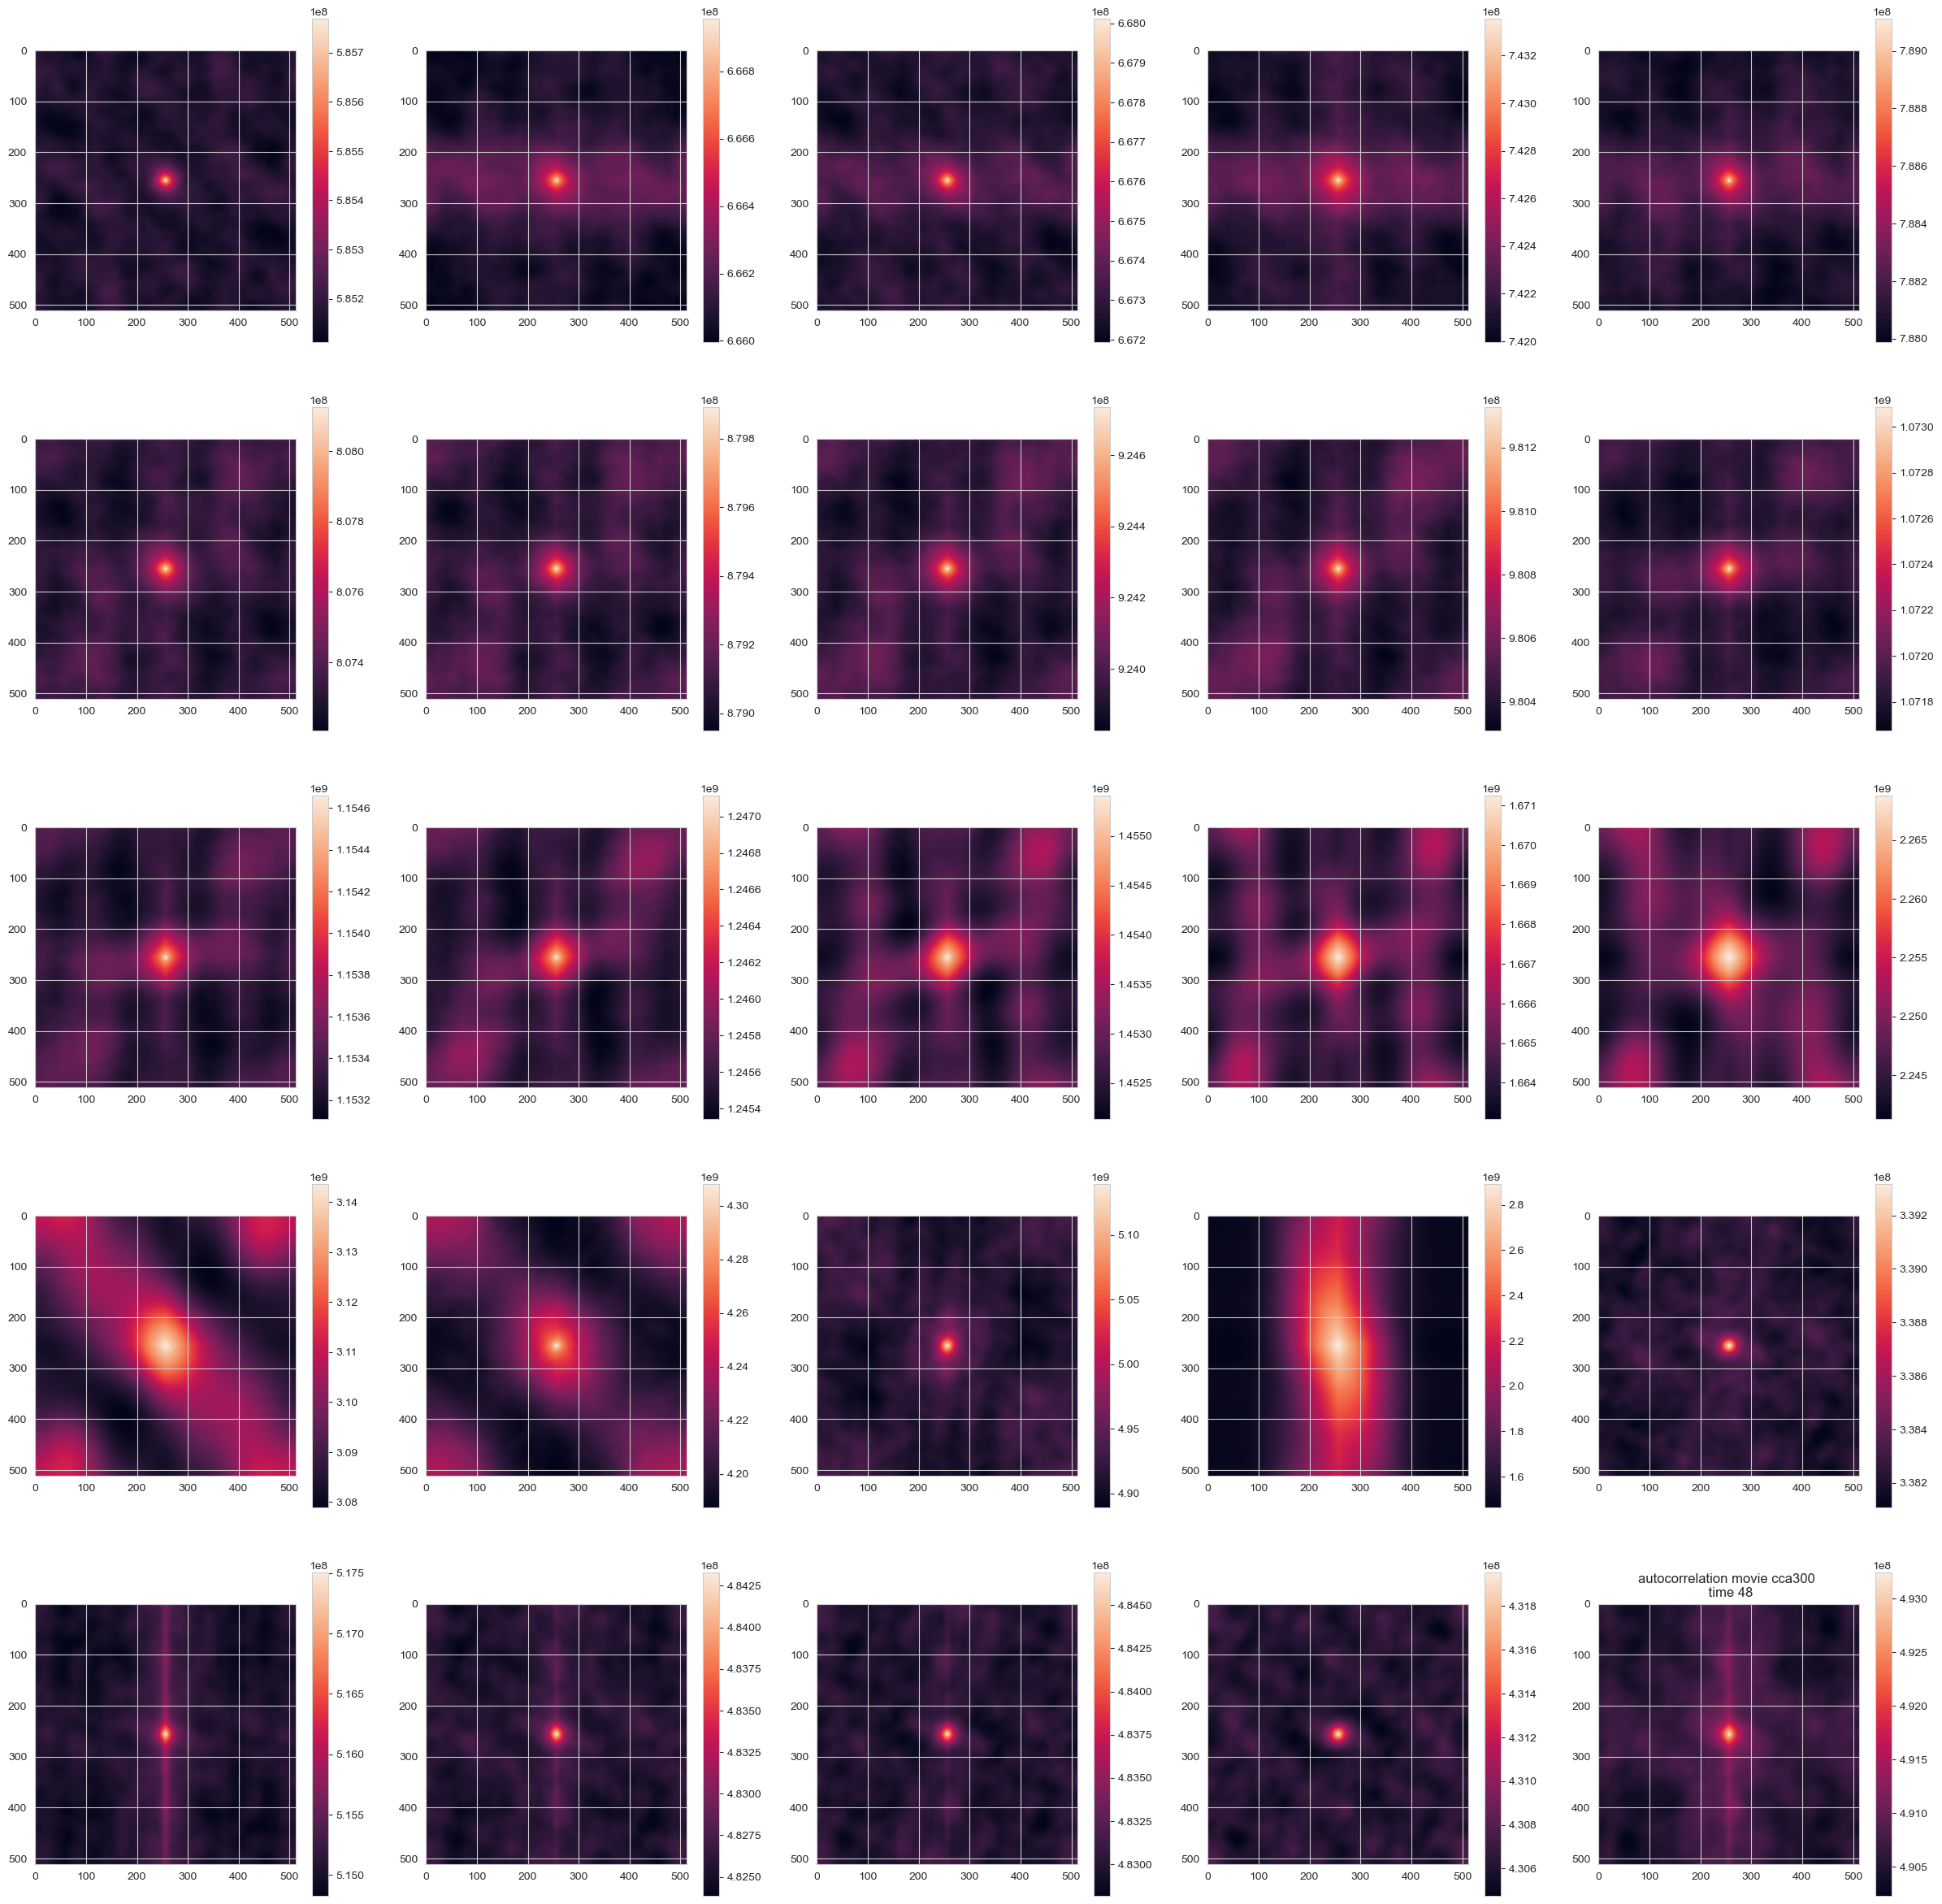

In [18]:
fig, axes = plt.subplots(5,5, figsize=(30,30))
axes = axes.ravel()
for i,t in enumerate(range(0, len(result),2)):
    im =axes[i].imshow(result[t])
    plt.colorbar(im, ax=axes[i])  # This adds a colorbar to the subplot.

plt.title('autocorrelation movie {} \n time {}'.format(movie,t))

plt.show()

In [24]:
import numba
import numpy
from tqdm.notebook import  trange, tqdm


def ipcf_cross_optimized(image_timeseries1, image_timeseries2, circle_coordinates, bins, **kwargs):
    """Return pair correlation function analysis of image time series."""
    ntimes, height, width = image_timeseries1.shape
    npoints = len(circle_coordinates)
    nbins = len(bins)
    radius = circle_coordinates[0, 0]

    result = numpy.zeros(
        (height - 2 * radius, width - 2 * radius, npoints, nbins),
        numpy.float32,
    )

    # make time axis last dimension
    data1 = numpy.moveaxis(image_timeseries1, 0, -1)

    # pre-calculate forward DFT along time axis
    rfft_buffer1 = numpy.fft.rfft(data1, axis=-1)
    data2 = numpy.moveaxis(image_timeseries2, 0, -1)

    # pre-calculate forward DFT along time axis
    rfft_buffer2 = numpy.fft.rfft(data2, axis=-1)


    for y in trange(radius, height - radius):
        for x in range(radius, width - radius):
            rfft_a = rfft_buffer1[y, x].conj()

            for i in range(npoints):
                # continue if output was already calculated
                if result[y - radius, x - radius, i, 0] != 0.0:
                    continue

                u, v = circle_coordinates[i]
                rfft_b = rfft_buffer2[y + v, x + u]

                # cross-correlate b and a
                c = numpy.fft.irfft(rfft_a * rfft_b)

                scale = ntimes / rfft_a[0].real / rfft_b[0].real

                # positive delays
                average_smooth_scale(
                    c, bins, scale, result[y - radius, x - radius, i]
                )

                # negative delays
                if (
                        radius <= y + v < height - radius
                        and radius <= x + u < width - radius
                ):
                    c = numpy.fft.fftshift(c)
                    i = (i + npoints // 2) % npoints
                    average_smooth_scale(
                        c[ntimes // 2: 0: -1],
                        bins,
                        scale,
                        result[y + v - radius, x + u - radius, i],
                    )

    return result


@numba.jit(nogil=True)
def average_smooth_scale(c, bins, scale, out):
    """Average, smooth, and scale correlation function."""
    # average
    out[0] = numpy.mean(c[: bins[0]])
    for i in range(len(bins) - 1):
        out[i + 1] = numpy.mean(c[bins[i]: bins[i + 1]])

    # smooth
    out[0] = out[1]
    for i in range(1, len(bins)):
        out[i] = out[i] * 0.3 + out[i - 1] * 0.7
    for i in range(len(bins) - 2, -1, -1):
        out[i] = out[i] * 0.3 + out[i + 1] * 0.7

    # scale
    out *= scale
    out -= 1.0

In [33]:
sinn = sur_intensity.copy()
sinn[np.isnan(sinn)] = np.nanmean(sinn)
minn = mem_intensity.copy()
minn[np.isnan(minn)] = np.nanmean(minn)

In [34]:

%time ipcf_result = run_ipcf_cross(ipcf_cross_optimized, minn, sinn)

  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: total: 1min 34s
Wall time: 1min 34s


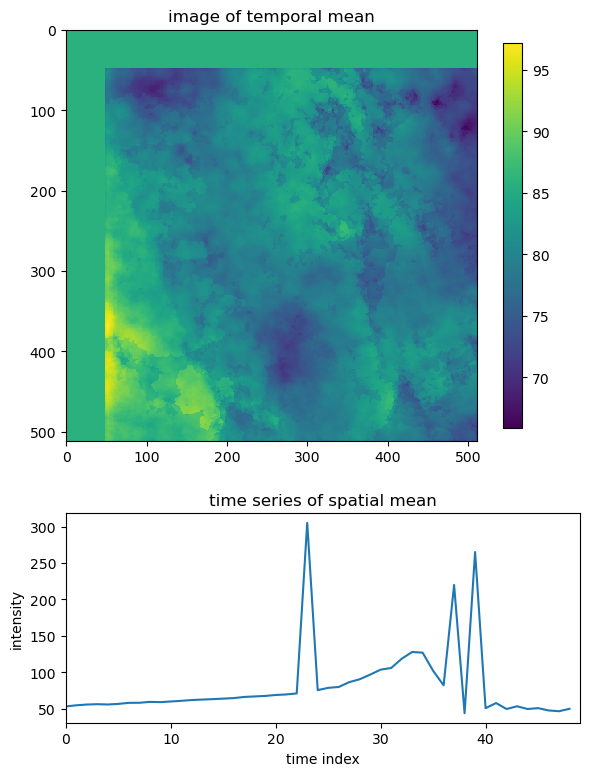

In [28]:
from matplotlib import pyplot


def plot_image_timeseries(image_timeseries):
    """Plot temporal and spatial means of image timeseries."""
    pyplot.figure(figsize=(6, 8))

    pyplot.subplot(3, 1, (1, 2))
    mean_image = numpy.nanmean(image_timeseries, axis=0)
    pyplot.title('image of temporal mean')
    pyplot.imshow(mean_image, cmap='viridis', interpolation='none')
    pyplot.colorbar(shrink=0.83, pad=0.05)

    pyplot.subplot(3, 1, 3)
    mean_ts = numpy.nanmean(image_timeseries, axis=(1, 2))
    pyplot.title('time series of spatial mean')
    pyplot.xlabel('time index')
    pyplot.ylabel('intensity')
    pyplot.plot(mean_ts)
    pyplot.xlim([0, len(mean_ts)])

    pyplot.tight_layout()
    pyplot.show()


plot_image_timeseries(SIMULATION_DATA)

In [36]:
import numpy


def correlate_circular(a, b):
    """Return circular correlation of two arrays using DFT."""
    size = a.size

    # forward DFT
    a = numpy.fft.rfft(a)
    b = numpy.fft.rfft(b)
    # multiply by complex conjugate
    c = a.conj() * b
    # reverse DFT
    c = numpy.fft.irfft(c)

    # positive delays only
    c = c[: size // 2]

    # normalize with the averages of a and b
    #   c is already normalized by size
    #   the 0th value of the DFT contains the sum of the signal
    c /= a[0].real * b[0].real / size
    c -= 1.0

    return c


def correlate_linear(a, b):
    """Return linear correlation of two arrays using DFT."""
    size = a.size

    # subtract mean and pad with zeros to twice the size
    a_mean = a.mean()
    b_mean = b.mean()
    a = numpy.pad(a - a_mean, a.size // 2, mode='constant')
    b = numpy.pad(b - b_mean, b.size // 2, mode='constant')

    # forward DFT
    a = numpy.fft.rfft(a)
    b = numpy.fft.rfft(b)
    # multiply by complex conjugate
    c = a.conj() * b
    # reverse DFT
    c = numpy.fft.irfft(c)
    # positive delays only
    c = c[: size // 2]

    # normalize with the averages of a and b
    c /= size * a_mean * b_mean

    return c


def average(c, bins):
    """Return averaged chunks of array."""
    out = [numpy.mean(c[: bins[0]])]
    for i in range(len(bins) - 1):
        out.append(numpy.mean(c[bins[i]: bins[i + 1]]))
    return out


def logbins(size, nbins):
    """Return up to nbins exponentially increasing integers from 1 to size."""
    b = numpy.logspace(0, math.log(size, 2), nbins, base=2, endpoint=True)
    return numpy.unique(b.astype(numpy.intp))


def smooth(c):
    """Return double exponentially smoothed array."""
    out = c.copy()
    out[0] = out[1]
    for i in range(1, len(out)):
        out[i] = out[i] * 0.3 + out[i - 1] * 0.7
    for i in range(len(out) - 2, -1, -1):
        out[i] = out[i] * 0.3 + out[i + 1] * 0.7
    return out

In [16]:
from ipywidgets import IntSlider, interact
from matplotlib import pyplot


def plot_pcf_processing(image_timeseries):
    """Compare linear and circular pair correlation functions."""
    ntimes, height, width = image_timeseries.shape

    def _plot(y0, x0, y1, x1):
        # select time series from image_timeseries
        a = image_timeseries[:, y0, x0]
        b = image_timeseries[:, y1, x1]
        a[np.isnan(a)] = np.nanmean(a)
        b[np.isnan(b)] = np.nanmean(b)

        # linear and circular correlation
        cl = correlate_linear(a, b)
        cc = correlate_circular(a, b)

        # average and smooth
        bins = logbins(a.size // 2, 32)
        averagedl = average(cl, bins)
        smoothedl = smooth(averagedl)
        averagedc = average(cc, bins)
        smoothedc = smooth(averagedc)

        pyplot.figure(figsize=(6, 12))

        # plot the time series
        pyplot.subplot(4, 1, 1)
        pyplot.title('time series')
        pyplot.xlabel('time index')
        pyplot.ylabel('intensity')
        pyplot.plot(a, 'g', label='[{}, {}]'.format(y0, x0))
        pyplot.plot(b, 'b', label='[{}, {}]'.format(y1, x0))
        pyplot.xlim([0, len(a)])
        pyplot.legend(fancybox=True, framealpha=0.9)

        # plot the cross-correlation function and logbins
        pyplot.subplot(4, 1, 2)
        pyplot.title('normalized cross-correlation functions and logbins')
        pyplot.xlabel('positive time delay index')
        pyplot.ylabel('correlation')
        for x in bins:
            pyplot.axvline(x=x, color='0.8')
        pyplot.plot(cl, 'g', label='linear')
        pyplot.plot(cc, 'b', label='circular')
        pyplot.xlim([0, len(cc)])
        pyplot.legend(fancybox=True, framealpha=0.9)

        # log-plot the cross-correlation function and logbins
        pyplot.subplot(4, 1, 3)
        pyplot.title('log-plot of cross-correlation functions and logbins')
        pyplot.xlabel('positive time delay index')
        pyplot.ylabel('correlation')
        for x in bins:
            pyplot.axvline(x=x, color='0.8')
        pyplot.semilogx(cl, 'g', label='linear', base=2)
        pyplot.semilogx(cc, 'b', label='circular', base=2)
        pyplot.xlim([0, len(cc)])
        pyplot.legend(fancybox=True, framealpha=0.9)

        # plot the binned and smoothed cross-correlation function
        pyplot.subplot(4, 1, 4)
        pyplot.title('averaged and smoothed cross-correlation functions')
        pyplot.xlabel('positive log time delay index')
        pyplot.ylabel('correlation')
        pyplot.plot(averagedl, 'g', label='linear')
        pyplot.plot(smoothedl, 'm')
        pyplot.plot(averagedc, 'b', label='circular')
        pyplot.plot(smoothedc, 'r', label='smoothed')
        pyplot.legend(fancybox=True, framealpha=0.9)

        pyplot.tight_layout()
        pyplot.show()

    interact(
        _plot,
        y0=IntSlider(31, 0, height - 1, continuous_update=False),
        x0=IntSlider(31, 0, width - 1, continuous_update=False),
        y1=IntSlider(35, 0, height - 1, continuous_update=False),
        x1=IntSlider(35, 0, width - 1, continuous_update=False),
    )


plot_pcf_processing(SIMULATION_DATA)

interactive(children=(IntSlider(value=31, continuous_update=False, description='y0', max=511), IntSlider(value…

In [40]:
import numpy
from ipywidgets import Dropdown, IntSlider, interact
from matplotlib import pyplot


def plot_ipcf_sprites(ipcf_result, figsize=(6, 5)):
    """Interactively plot pair correlation functions at pixel."""
    height, width, npoints, nbins = ipcf_result.shape

    # data limits
    vmax, vmin = numpy.max(ipcf_result), numpy.min(ipcf_result)
    vminmax = max(abs(vmax), abs(vmin))

    # coordinates for polar plot and Delaunay triangulation
    radius = numpy.arange(nbins)
    angles = numpy.linspace(0, 2 * numpy.pi, npoints, endpoint=False)
    radius, angles = numpy.meshgrid(radius, angles)
    xcoords = radius * numpy.cos(angles)
    ycoords = radius * numpy.sin(-angles)

    def _plot(style, y, x):
        pyplot.figure(figsize=figsize)
        pyplot.title('pair correlation functions at pixel')
        sprite = ipcf_result[y, x]
        if style == 'lines':
            pyplot.plot(sprite.T, 'b')
            pyplot.ylim([vmin, vmax])
            pyplot.xlabel('log time delay index')
            pyplot.ylabel('pcf')
        elif style == 'carpet':
            pyplot.imshow(
                sprite,
                vmin=-vminmax,
                vmax=vminmax,
                cmap='seismic',
                interpolation='none',
            )
            pyplot.xlabel('log time delay index')
            pyplot.ylabel('circle point index')
            pyplot.colorbar()
        elif style == 'polar':
            # polar plot using Delaunay triangulation
            pyplot.tripcolor(
                xcoords.flat,
                ycoords.flat,
                sprite.flat,
                vmin=-vminmax,
                vmax=vminmax,
                shading='gouraud',
                cmap='seismic',
            )
            pyplot.axes().set_aspect('equal')
            pyplot.axis('off')
            pyplot.colorbar()
        pyplot.show()

    interact(
        _plot,
        style=Dropdown(options=['carpet', 'polar', 'lines']),
        y=IntSlider(height // 2, 0, height - 1, continuous_update=False),
        x=IntSlider(width // 2, 0, width - 1, continuous_update=False),
    )


plot_ipcf_sprites(ipcf_result)

interactive(children=(Dropdown(description='style', options=('carpet', 'polar', 'lines'), value='carpet'), Int…

In [32]:
import numpy
from ipywidgets import IntSlider, interact
from matplotlib import pyplot


def plot_ipcf_images(ipcf_result, figsize=(6, 5), interpolation='none'):
    """Interactively plot image of pair correlation function values."""
    height, width, npoints, nbins = ipcf_result.shape
    transpose = height > 1.5 * width

    # data limits
    vmax, vmin = numpy.max(ipcf_result), numpy.min(ipcf_result)
    vminmax = max(abs(vmax), abs(vmin))

    def _plot(point, bin):
        pyplot.figure(figsize=figsize)
        image = ipcf_result[:, :, point, bin]
        if transpose:
            image = image.T
        angle = 360.0 / npoints * point
        pyplot.title('pair correlation function values')
        pyplot.imshow(
            image,
            vmin=-vminmax,
            vmax=vminmax,
            cmap='seismic',
            interpolation=interpolation,
        )
        orientation = 'horizontal' if transpose else 'vertical'
        pyplot.colorbar(orientation=orientation)
        pyplot.show()

    interact(
        _plot,
        point=IntSlider(npoints // 2, 0, npoints - 1, continuous_update=False),
        bin=IntSlider(nbins // 2, 0, nbins - 1, continuous_update=False),
    )


plot_ipcf_images(ipcf_result)

interactive(children=(IntSlider(value=16, continuous_update=False, description='point', max=31), IntSlider(val…